##Cleaning the data
This notebook contains the steps I took to clean the data and exports the cleaned data as a dataframe pickle.

In [25]:
import pandas as pd
import seaborn as sns
import gc
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [8]:
%cd /content/gdrive/My Drive/Github/capstone

/content/gdrive/My Drive/Github/capstone


In [9]:
# import my custom library into colab
import sys
sys.path.append('/content/gdrive/MyDrive/Github/capstone/libraries')
import mylibrary as mylib

In [10]:
# read in pickles created in ./notebooks/data_download.ipynb
df = pd.read_pickle('./data/master_data.pkl') # data with the patent claims
df_pats_w_sectors = pd.read_pickle('./data/pats_w_sectors.pkl') # data with the classifications

In [11]:
# This function takes the master dataframe, merges it with the classification 
# dataframe, and returns the cleaned copy
df_master = mylib.merge_and_clean(df_pats_w_sectors, df)

In [12]:
# Drop "other fiends" classification since I'm treating this as a lack of a classification
df_master = df_master[df_master.sector!='Other fields']
df_master

,patent_id,sector,text
0,10001059,Mechanical engineering,1. A method of removing a tower shaft of a gas...
1,10189524,Mechanical engineering,"1. A two-wheeled vehicle, comprising: a frame ..."
2,10309306,Mechanical engineering,1. A turbofan engine comprising: a fan rotatab...
3,10427924,Mechanical engineering,1. An industrial truck comprising: a mast; a l...
4,10428949,Mechanical engineering,1. A header ring comprising: an opening; a rad...
...,...,...,...
2265879,10800649,Chemistry,1. A microelectromechanical systems (MEMS) dev...
2265880,10800650,Chemistry,1. A semiconductor device comprising: a cavity...
2265881,10807862,Chemistry,"1. A semiconductor device, comprising: a semic..."
2265882,10807863,Chemistry,1. A method for manufacturing micromechanical ...


In [13]:
# can uncomment below to truncate data for testing purposes, otherwise run as-is
# for full data set
df = df_master#[:int(len(df_master.patent_id)*0.8)]

I wanted to get a sense for the amount of data we had for each class, so I plotted count plots for each category.

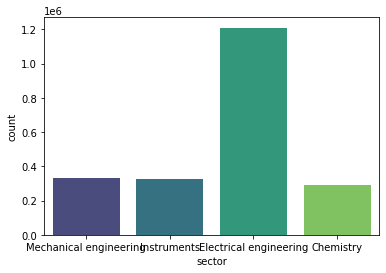

In [14]:
# Look at the counts for each category
ax = sns.countplot(x='sector', data=df, palette='viridis')

In [15]:
# Take a look at the actual numbers for the counts.
sizes = pd.DataFrame()
sizes['sector'] = list(set(df.sector))
sizes['sector_count'] = [len(df[df.sector==sector]) for sector in sizes.sector]
sizes

,sector,sector_count
0,Chemistry,291608
1,Mechanical engineering,333013
2,Electrical engineering,1209981
3,Instruments,324065


There is an imbalance favoring "Electrical engineering", but we have plenty of data, so I used a subset of the data to balance the classes.

In [16]:
# Take 200k from each class. I limited to this amount to help with computing times.
class_size = 200000
trimmed_df = pd.DataFrame()
for sector in sizes.sector:
  group = df[df.sector == sector][:class_size]
  trimmed_df = trimmed_df.append(group)
trimmed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800000 entries, 1072449 to 733100
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   patent_id  800000 non-null  int64 
 1   sector     800000 non-null  object
 2   text       800000 non-null  object
dtypes: int64(1), object(2)
memory usage: 24.4+ MB


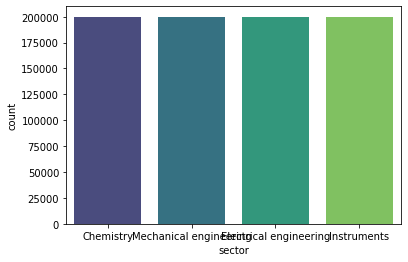

In [17]:
# Verify the classes are all equal.
ax = sns.countplot(x='sector', data=trimmed_df, palette='viridis')

In [18]:
# Do some memory management and split into X and y sets
del df
df = trimmed_df
y = df['sector']
X = df['text']
del trimmed_df
gc.collect()

2424

In [19]:
# Pickle the split dataset with all 4 classes
y.to_pickle('data/y_4class.pkl')
X.to_pickle('data/X_4class.pkl')

In [20]:
# Create training and test sets with all classes and then pickling y sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)
y_train.to_pickle('data/y_train_4class.pkl')
y_test.to_pickle('data/y_test_4class.pkl')

I chose Tfidf for the vectorizer, since it tends to work best for NLP. I filtered out the top and bottom 10% common words. From trial and error, this percentage gave a good balance of computing time with my resources but without sacrificing too much accuracy. As I progressed in this project, computing times hours and hours became a matter of issue, so it has driven several of the decisions made in this project. It is also how I selected the length of n grams. 

In [21]:
# Vectorize data
vec = TfidfVectorizer(analyzer=mylib.preprocess_text,
                      ngram_range=(1,3),
                      min_df=0.1,
                      max_df=0.9)

In [ ]:
# Vectorize data for train and test sets, then pickle them for later
X_train_transformed = vec.fit_transform(X_train).toarray()

In [26]:
pickle.dump(vec, open('/content/gdrive/MyDrive/Github/capstone/data/vec_4class.pkl', 'wb'))

In [ ]:
X_train_transformed = vec.fit_transform(X_train).toarray()
X_train = pd.DataFrame(X_train_transformed, columns = vec.get_feature_names())
X_train.to_pickle('data/X_train_4class.pkl')

In [ ]:
X_test_transformed = vec.transform(X_test).toarray()
X_test = pd.DataFrame(X_test_transformed, columns = vec.get_feature_names())
X_test.to_pickle('data/X_test_4class.pkl')

In [ ]:
# Memory management
del X_train
del X_test
del y_train
del y_test
del X_train_transformed
del X_test_transformed
gc.collect()

50

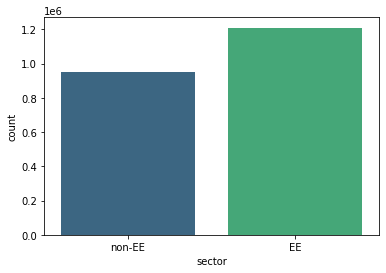

In [ ]:
# Create dataset with 2 classes, Electrical and non-Electrical
df_2class = df_master
df_2class.sector = df_2class.sector.replace('Chemistry', 'non-EE')
df_2class.sector = df_2class.sector.replace('Instruments', 'non-EE')
df_2class.sector = df_2class.sector.replace('Mechanical engineering', 'non-EE')
df_2class.sector = df_2class.sector.replace('Electrical engineering', 'EE')
ax = sns.countplot(x='sector', data=df_2class, palette='viridis')

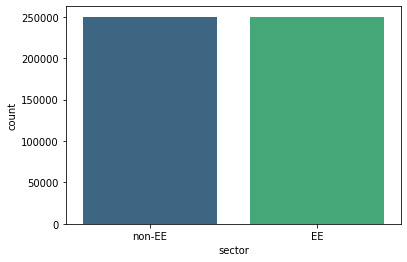

In [ ]:
# Limit to 250k from each class. I limited to this amount to help with computing times.
class_size = 250000
trimmed_df = pd.DataFrame()
for sector in ['non-EE', 'EE']:
  group = df_2class[df_2class.sector == sector][:class_size]
  trimmed_df = trimmed_df.append(group)
ax = sns.countplot(x='sector', data=trimmed_df, palette='viridis')
y = df_2class['sector']
X = df_2class['text']

In [ ]:
# Dataset with 2 classes
y.to_pickle('./data/y_2class.pkl')
X.to_pickle('./data/X_2class.pkl')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)
y_train.to_pickle('./data/y_train_2class.pkl')
y_test.to_pickle('./data/y_test_2class.pkl')

In [ ]:
X_train_transformed = vec.fit_transform(X_train).toarray()
X_train = pd.DataFrame(X_train_transformed, columns = vec.get_feature_names())
X_train.to_pickle('./data/X_train_2class.pkl')

X_test_transformed = vec.transform(X_test).toarray()
X_test = pd.DataFrame(X_test_transformed, columns = vec.get_feature_names())
X_test.to_pickle('./data/X_test_2class.pkl')

### Holdout Data Set
Create set of holdout data. Clean using same steps as before

In [27]:
holdout = pd.read_pickle('./data/holdout_2010_data.pkl')# data with the patent claims

In [28]:
df_pats_w_sectors = pd.read_pickle('./data/pats_w_sectors.pkl') # data with the classifications

In [29]:
holdout = mylib.merge_and_clean(df_pats_w_sectors, holdout)

In [30]:
holdout = holdout.drop(columns = 'sector_y')
holdout = holdout.rename(columns={'sector_x':'sector'})
holdout.head()

,patent_id,sector,text
0,7640634,Mechanical engineering,1. A fastener comprising a main body and a win...
1,7640635,Mechanical engineering,1. A fixing clip for securing an interior part...
2,7640707,Mechanical engineering,1. A fastening clip configured to secure a fir...
3,7640734,Mechanical engineering,1. A vehicular torque converter comprising: a ...
4,7640735,Mechanical engineering,1. An auxiliary hydraulic pump assembly for a ...


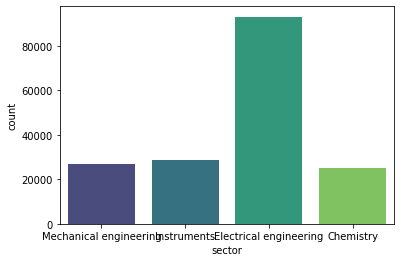

In [31]:
holdout = holdout[holdout.sector!='Other fields']
# Look at the counts for each category
ax = sns.countplot(x='sector', data=holdout, palette='viridis')

In [32]:
# Take a look at the actual numbers for the counts.
sizes = pd.DataFrame()
sizes['sector'] = list(set(holdout.sector))
sizes['sector_count'] = [len(holdout[holdout.sector==sector]) for sector in sizes.sector]
sizes

,sector,sector_count
0,Chemistry,25202
1,Mechanical engineering,26970
2,Electrical engineering,93171
3,Instruments,28782


In [33]:
# Take 200k from each class. I limited to this amount to help with computing times.
class_size = 20000
trimmed_df = pd.DataFrame()
for sector in sizes.sector:
  group = holdout[holdout.sector == sector][:class_size]
  trimmed_df = trimmed_df.append(group)
trimmed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80000 entries, 80138 to 53984
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patent_id  80000 non-null  int64 
 1   sector     80000 non-null  object
 2   text       80000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.4+ MB


Create holdout X and y sets and pickle everything.

In [34]:
X = holdout.text
y = holdout.sector

In [35]:
y.to_pickle('./data/y_holdout.pkl')

In [36]:
vec = pickle.load(open('./data/vec_4class.pkl', 'rb'))
X_transformed = vec.transform(X).toarray()
X = pd.DataFrame(X_transformed, columns = vec.get_feature_names())
# Pickled holdout data
X.to_pickle('./data/X_holdout.pkl')